In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import tensorflow as tf
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from nltk.stem import SnowballStemmer
from sklearn.preprocessing import LabelEncoder
import joblib
import os

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/fahrialmd/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/fahrialmd/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/fahrialmd/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [13]:
# Load the dataset
df = pd.read_csv('tabel_artikel.csv')
khasiat = pd.concat([df['id'], df['nama_obat'], df['khasiat']], axis=1)

# Append the values from "nama_obat" to "khasiat"
khasiat['khasiat'] = khasiat['nama_obat'] + ' ' + khasiat['khasiat']


# Save the modified dataframe to a new CSV file
khasiat.to_csv('khasiat.csv', index=False)


In [14]:
# Shuffle the dataset
df = shuffle(df, random_state=42)

def preProcessing(df, col):
    # Lowercase the text
    df[f'{col}'] = df[f'{col}'].str.lower()

    # Remove special characters and numbers
    df[f'{col}'] = df[f'{col}'].apply(lambda x: re.sub(r'\d+|\$', '', x))
    df[f'{col}'] = df[f'{col}'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

    # Tokenization
    df[f'{col}'] = df[f'{col}'].apply(lambda x: word_tokenize(x))

    # Remove stop words
    stop_words = set(stopwords.words('indonesian'))
    df[f'{col}'] = df[f'{col}'].apply(lambda x: [word for word in x if word not in stop_words])

    # Convert the preprocessed data back to string
    df[f'{col}'] = df[f'{col}'].apply(lambda x: ' '.join(x))
    return df

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(df['text'], df['category'], test_size=0.2, random_state=42)

def plot(data, title):
    val_count = data.khasiat.value_counts()
    plt.figure(figsize=(8,4))
    plt.bar(val_count.index, val_count.values)
    plt.title(title)



In [15]:
khasiat = preProcessing(khasiat, 'khasiat')
khasiat.to_csv('khasiat.csv')
khasiat

,id,nama_obat,khasiat
0,1,Adas,adas sakit perut mulas perut kembung mual munt...
1,2,Ajeran,ajeran bisul gatal gatal sakit gigi sakit mata
2,3,Akar Kuning,akar kuning antioksidan antibiotik antikanker ...
3,4,Akar Wangi,akar wangi bau keringat bau mulut encok pegalp...
4,5,Alamanda,alamanda disentri keracunan malaria
...,...,...,...
260,261,Urang Aring,urang aring pencarah batuk darah sakit gigi pa...
261,262,Vanili,vanili sakit kepala
262,263,Widelia,widelia digigit serangga luka sayatan luka ber...
263,264,Wijayakusuma,wijayakusuma luka bisul tbc asma batuk batuk d...


In [16]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(khasiat['khasiat'])

In [17]:
# Train a Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_tfidf, khasiat['khasiat'])

MultinomialNB()

In [18]:
# Using TensorFlow for evaluation

# Convert labels to numerical values
all_labels = np.unique(khasiat['nama_obat'])
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)
train_labels_encoded = label_encoder.fit_transform(khasiat['nama_obat'])

# Convert labels to one-hot encoding
num_classes = len(label_encoder.classes_)
y_train_encoded = tf.keras.utils.to_categorical(train_labels_encoded, num_classes=num_classes)
num_classes

265

In [19]:
# Define a simple neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train_tfidf.shape[1],)),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

2023-06-12 20:40:20.265306: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-06-12 20:40:20.308373: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-12 20:40:20.308629: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3050 Laptop GPU computeCapability: 8.6
coreClock: 1.5GHz coreCount: 16 deviceMemorySize: 3.82GiB deviceMemoryBandwidth: 178.84GiB/s
2023-06-12 20:40:20.309375: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/fahrialmd/catkin_ws/devel/lib:/opt/ros/noetic/lib:/usr/local/cuda-11.8/lib64:/usr/lib/x

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                44096     
_________________________________________________________________
dense_1 (Dense)              (None, 265)               17225     
Total params: 61,321
Trainable params: 61,321
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Compile and train the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_tfidf.toarray(), y_train_encoded, epochs=2000, batch_size=32, verbose=1)

Epoch 1/2000
9/9 [==============================] - 0s 888us/step - loss: 5.5833 - accuracy: 0.0000e+00
Epoch 2/2000
9/9 [==============================] - 0s 851us/step - loss: 5.5609 - accuracy: 0.0453
Epoch 3/2000
9/9 [==============================] - 0s 977us/step - loss: 5.5416 - accuracy: 0.1321
Epoch 4/2000
9/9 [==============================] - 0s 1ms/step - loss: 5.5204 - accuracy: 0.3094
Epoch 5/2000
9/9 [==============================] - 0s 2ms/step - loss: 5.4954 - accuracy: 0.4943
Epoch 6/2000
9/9 [==============================] - 0s 1ms/step - loss: 5.4674 - accuracy: 0.6491
Epoch 7/2000
9/9 [==============================] - 0s 1ms/step - loss: 5.4340 - accuracy: 0.7585
Epoch 8/2000
9/9 [==============================] - 0s 1ms/step - loss: 5.3962 - accuracy: 0.8226
Epoch 9/2000
9/9 [==============================] - 0s 1ms/step - loss: 5.3539 - accuracy: 0.8755
Epoch 10/2000
9/9 [==============================] - 0s 1ms/step - loss: 5.3059 - accuracy: 0.9283
Epoch 11/

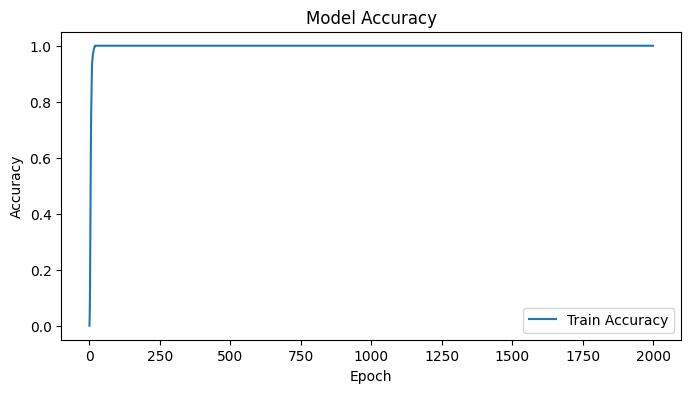

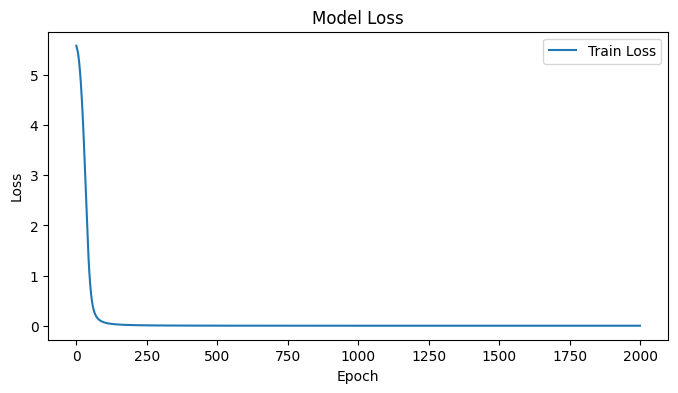

In [22]:
# Extract accuracy and loss values from the training history
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']


# Plot accuracy curves
plt.figure(figsize=(8, 4))
plt.plot(train_accuracy, label='Train Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss curves
plt.figure(figsize=(8, 4))
plt.plot(train_loss, label='Train Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
if os.path.exists('tf-model'):
    pass
else:
    !mkdir tf-model
# Save the model in HDF5 format (.h5)
model.save('tf-model/artikel-obat-model.h5')
# Save the vectorizer and label encoder
joblib.dump(vectorizer, 'tf-model/vectorizer.pkl')
joblib.dump(label_encoder, 'tf-model/label_encoder.pkl')

# Save the model in Protocol Buffer format (.pb)
# tf.saved_model.save(model, 'artikel-obat-model.pb')
# Load the saved model
# model = tf.keras.models.load_model('artikel-obat-model.h5')

['tf-model/label_encoder.pkl']

In [26]:
# Save the JSON model to a file

if os.path.exists('tfjs-model'):
    pass
else:
    !mkdir tfjs-model

!tensorflowjs_converter --input_format=keras artikel-obat-model.h5 tfjs-model/


Traceback (most recent call last):
  File "/home/fahrialmd/Programs/anaconda3/envs/ml/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
  File "/home/fahrialmd/Programs/anaconda3/envs/ml/lib/python3.7/site-packages/tensorflowjs/converters/converter.py", line 827, in pip_main
    main([' '.join(sys.argv[1:])])
  File "/home/fahrialmd/Programs/anaconda3/envs/ml/lib/python3.7/site-packages/tensorflowjs/converters/converter.py", line 831, in main
    convert(argv[0].split(' '))
  File "/home/fahrialmd/Programs/anaconda3/envs/ml/lib/python3.7/site-packages/tensorflowjs/converters/converter.py", line 818, in convert
    weight_shard_size_bytes, metadata_map)
  File "/home/fahrialmd/Programs/anaconda3/envs/ml/lib/python3.7/site-packages/tensorflowjs/converters/converter.py", line 505, in _dispatch_converter
    metadata=metadata_map)
  File "/home/fahrialmd/Programs/anaconda3/envs/ml/lib/python3.7/site-packages/tensorflowjs/converters/converter.py", line 76, in dispatc

In [27]:
def preprocess_input_text(input_text):
    # Lowercase the text
    input_text = input_text.lower()

    # Remove special characters and numbers
    input_text = re.sub(r'\d+|\$', '', input_text)
    input_text = input_text.translate(str.maketrans('', '', string.punctuation))

    # Tokenization
    input_text = word_tokenize(input_text)

    # Remove stop words
    stop_words = set(stopwords.words('indonesian'))
    input_text = [word for word in input_text if word not in stop_words]

    # Convert the preprocessed data back to string
    input_text = ' '.join(input_text)

    return input_text

In [32]:
# Preprocess the input data
input_text = 'akar wangi'
input_text = preprocess_input_text(input_text) # Replace 'your input text' with the actual text you want to predict

# Transform the input text using the same vectorizer used during training
input_text_tfidf = vectorizer.transform([input_text])

# Make predictions using the loaded model
predictions = model.predict(input_text_tfidf.toarray())

# Get the top 5 predicted labels and their corresponding probabilities
top_k = 5
top_k_indices = np.argsort(predictions, axis=1)[:, -top_k:][0]
top_k_probabilities = predictions[0, top_k_indices]

# Convert the predicted label indices to category labels
predicted_labels = label_encoder.inverse_transform(top_k_indices)

# Print the top 5 predicted labels and their probabilities
out = []
print(f"User input: {input_text}")
print("Top 5 Predicted Labels:")
for label, probability in zip(predicted_labels, top_k_probabilities):
    out.append(f"{label}: {probability:.4f}")
out = out[::-1]
print('\n'.join(str(element) for element in out))


User input: akar wangi
Top 5 Predicted Labels:
Akar Wangi: 0.9972
Pandan Wangi: 0.0017
Akar Kuning : 0.0002
Johar: 0.0001
Jeruk Bali: 0.0001
